I grab the light curves for S82 quasars from a database named `ztf` on `epyc.astro.washington.edu` machine. They're all collected in a single table named `alerts`.  Heavily based on example of 
`epyc/users/zgolkhou/uw-ztf-database-demo.ipynb` . Thank you Zachary Golkhou! 

In [1]:
import pandas as pd
import numpy as np
import mysql.connector as mariadb
from astropy.time import Time
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns',100)
pd.set_option('float_format', '{:f}'.format)


from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join


"Connect to the database using the user `ztf`. There's no password. You *must* do this from epyc (the database is inaccessible outside epyc)."

In [2]:
con = mariadb.connect(user='ztf', database='ztf')
pd.read_sql_query('show tables;', con).values

array([['alerts'],
       ['alerts_ORG'],
       ['alerts_limmag'],
       ['summary']], dtype=object)

Find some more info about "summary" table : 

In [38]:
pd.read_sql_query('describe summary;', con)

,Field,Type,Null,Key,Default,Extra
0,objectId,varchar(20),NO,PRI,None,
1,meanRA,double,YES,,None,
2,meanDec,double,YES,,None,
3,nobs,int(11),YES,,None,
4,gNobs,int(11),YES,,None,
5,rNobs,int(11),YES,,None,
6,iNobs,int(11),YES,,None,
7,gMeanAB,float,YES,,None,
8,rMeanAB,float,YES,,None,
9,iMeanAB,float,YES,,None,


Table of contents : 

  * [simple example queries](#example_queries)
  * [obtain ZTF data for CW Leo AGB star ](#cw_leo)
  * [Check for ZTF data for S82 SDSS QSO ](#s82_qso)
  * [download the median ZTF data](#download_median_ztf)

"After that, it's easiest to use Pandas to execute queries. Below are some examples."

<a id='example_queries'></a>
    Sample first 10 rows to show the table structure : 

In [5]:
%%time
df = pd.read_sql_query('select * from alerts LIMIT 10', con)


CPU times: user 88.1 ms, sys: 5.57 ms, total: 93.7 ms
Wall time: 243 ms


In [6]:
df

,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,nid,rcid,field,xpos,ypos,ra,decl,magpsf,sigmapsf,chipsf,magap,sigmagap,distnr,magnr,sigmagnr,chinr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,magfromlim,seeratio,aimage,bimage,aimagerat,bimagerat,elong,nneg,nbad,rb,ssdistnr,ssmagnr,ssnamenr,sumrat,magapbig,sigmagapbig,ranr,decnr,sgmag1,srmag1,simag1,szmag1,sgscore1,distpsnr1,ndethist,ncovhist,jdstarthist,jdendhist,scorr,tooflag,objectidps1,objectidps2,sgmag2,srmag2,simag2,szmag2,sgscore2,distpsnr2,objectidps3,sgmag3,srmag3,simag3,szmag3,sgscore3,distpsnr3,nmtchps,rfid,jdstartref,jdendref,nframesref,rbversion,dsnrms,ssnrms,dsdiff,magzpsci,magzpsciunc,magzpscirms,nmatches,clrcoeff,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright
0,ZTF18aahinga,2458216.675926,2,462175923815,19.847500,1,462175923815010000,f,0,462,38,611,2611.640000,601.620000,83.950123,26.951459,19.584200,0.100120,0.714361,19.052400,0.085600,1.698290,19.850000,0.120000,4.807000,0.279000,0.947525,-0.531844,7.930000,0.055000,460.862000,0.795101,0.398599,1.783000,1.182000,0.224842,0.149054,1.508460,0,0,0.110000,-999.000000,-999.000000,,1.000000,18.809500,0.151900,83.949587,26.951482,21.349000,22.117200,-999.000000,-999.000000,0.500000,2.698130,2,193,2458216.671887,2458216.675926,11.262218,0,140340839508391569,140340839478855868,-999.000000,-999.000000,21.378800,-999.000000,0.672562,12.729300,140330839496818027,-999.000000,21.716300,20.865400,20.401400,0.132577,13.034900,14,611120238,2458160.722651,2458186.665903,17,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ZTF18aahinhb,2458216.675926,2,462175923815,19.847500,1,462175923815010001,f,1,462,38,611,665.048000,675.905000,84.564446,26.929695,20.102300,0.161061,0.469641,20.048400,0.212500,3.518630,21.447000,0.146000,0.983000,0.150000,6.682850,-0.053890,20.630000,0.538000,665.048000,-0.200899,0.153218,0.451000,0.339000,0.021861,0.016432,1.330380,3,0,0.203333,-999.000000,-999.000000,,1.000000,18.772200,0.147700,84.563636,26.929017,20.071700,19.042100,18.471700,18.145500,0.990875,7.531390,1,193,2458216.675926,2458216.675926,7.263019,0,140310845629368137,140310845609598319,-999.000000,21.408100,20.603400,20.129900,0.910896,12.882300,140310845684195579,20.385200,19.093700,17.977500,17.455700,0.957708,12.927300,18,611120238,2458160.722651,2458186.665903,17,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,ZTF18aahingv,2458216.675926,2,462175923815,19.847500,1,462175923815010002,f,2,462,38,611,621.718000,813.712000,84.577934,26.890878,19.688800,0.111339,0.649423,19.772500,0.165300,0.205755,19.294000,0.036000,1.313000,0.067000,2.859200,0.083738,4.020000,0.966000,621.718000,0.075000,0.786291,1.198000,1.029000,0.298010,0.255970,1.164240,4,0,0.420000,-999.000000,-999.000000,,0.991097,19.360700,0.252100,84.578000,26.890871,21.081200,19.793500,19.274400,18.938900,0.960208,0.222024,2,193,2458216.671887,2458216.675926,8.801106,0,140260845779919629,140270845746322645,-999.000000,-999.000000,21.122800,20.489100,0.780482,13.868900,140260845732418609,21.279100,20.033300,19.363300,18.955600,0.953958,15.353300,12,611120238,2458160.722651,2458186.665903,17,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,ZTF17aadkdbp,2458216.675926,2,462175923815,19.847500,1,462175923815010003,f,3,462,38,611,733.822000,929.138000,84.542418,26.858532,17.078000,0.017212,1.168850,17.088800,0.018400,0.131628,15.705000,0.015000,0.506000,-0.044000,0.893753,0.010753,3.160000,0.983000,733.822000,2.758700,1.000280,1.040000,1.019000,0.329114,0.322468,1.020610,0,0,0.606667,-999.000000,-999.000000,,1.000000,16.963700,0.029900,84.542437,26.858563,16.771700,15.827500,15.455000,15.358100,0.969583,0.095185,83,197,2458042.000359,2458216.675926,26.530439,0,140230845424180878,140220845446489414,-999.000000,-999.000000,21.490300,20.934100,0.600146,8.343180,140230845412273998,-999.000000,21.708600,21.

Useful ones (for now) :  `objectId,  jd,  fid, ra, decl, magpsf,  sigmapsf, classtar`  .   'fid' is   Filter ID (1=g; 2=r; 3=i). 

"The descriptions of these columns can be found at https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html."

In [5]:
df = pd.read_sql_query('select objectid, jd, fid, ra,decl,magpsf, sigmapsf, classtar from alerts LIMIT 10', con)

In [6]:
df

,objectid,jd,fid,ra,decl,magpsf,sigmapsf,classtar
0,ZTF18aahinga,2458216.675926,2,83.950123,26.951459,19.584200,0.100120,0.055000
1,ZTF18aahinhb,2458216.675926,2,84.564446,26.929695,20.102300,0.161061,0.538000
2,ZTF18aahingv,2458216.675926,2,84.577934,26.890878,19.688800,0.111339,0.966000
3,ZTF17aadkdbp,2458216.675926,2,84.542418,26.858532,17.078000,0.017212,0.983000
4,ZTF18aahinha,2458216.675926,2,83.954005,26.833443,20.341000,0.200630,0.012000
5,ZTF17aaczquf,2458216.675926,2,84.213927,26.835601,17.642300,0.042425,0.996000
6,ZTF17aaczqqk,2458216.675926,2,83.816397,26.822068,18.299600,0.084762,0.974000
7,ZTF17aadqfdv,2458216.675926,2,83.910289,26.727510,15.906900,0.008418,0.985000
8,ZTF17aadqffe,2458216.675926,2,84.218729,26.728875,18.682500,0.060897,0.976000
9,ZTF18aahings,2458216.675926,2,83.822478,26.701588,19.104500,0.131375,0.951000


<a id='cw_leo'></a>Grab the CW Leo light curve by name : 

In [3]:
df = pd.read_sql_query('SELECT objectid, jd, fid, ra,decl,magpsf, sigmapsf \
FROM alerts WHERE objectid = "ZTF18aahpgxj" ', con)  

In [4]:
df

,objectid,jd,fid,ra,decl,magpsf,sigmapsf
0,ZTF18aahpgxj,2458245.653194,2,146.989427,13.278551,17.547800,0.020409
1,ZTF18aahpgxj,2458257.728530,2,146.989323,13.278556,16.415100,0.012176
2,ZTF18aahpgxj,2458263.701250,2,146.989375,13.278534,16.163200,0.006661


Grab the CW Leo light curve by coords : 

In [20]:
#  30 arcsec  ==> 0.008333  degree (  30 / 3600 )
df = pd.read_sql_query('SELECT objectid, jd, fid, ra,decl,magpsf, sigmapsf \
FROM alerts WHERE (decl > 13.278767-0.008333 ) && (decl < 13.278767+0.008333) \
AND (146.98921-0.008333 < ra) && ( ra < 146.98921+0.008333)  ', con)  

In [24]:
tb = Table.from_pandas(df)

In [26]:
tb.write('ZTF18aahpgxj.txt', format='ascii')

In [27]:
pwd

'/data/epyc/users/suberlak'

<a id='s82_qso'></a>
Grab the S82 QSO database: 

In [5]:
# Check how many SDSS S82 DR9 QSOs have PS1 matches 
File = 'DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

# 9258 QSO ....
SDSS_DB_QSO= Table.read(File, format='ascii', names = colnames)

In [34]:
SDSS_DB_QSO

dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116
98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183
233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154
1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178
1310,0.221552,-0.292485,36,-26.451,-26.974,2.7563,9.361,46.76,20.707,19.663,19.61,19.705,19.529,0.174
1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139
1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122
1580,1.669492,0.643952,229,-24.427,-24.898,1.3383,8.666,45.862,20.732,20.572,20.13,20.079,20.231,0.207
2113,4.850273,-0.276395,699,-25.251,-25.695,1.769,0.0,0.0,19.956,20.066,20.152,19.886,19.618,0.147


0.027228 359.997681
-1.265148 1.266716


<IPython.core.display.Javascript object>


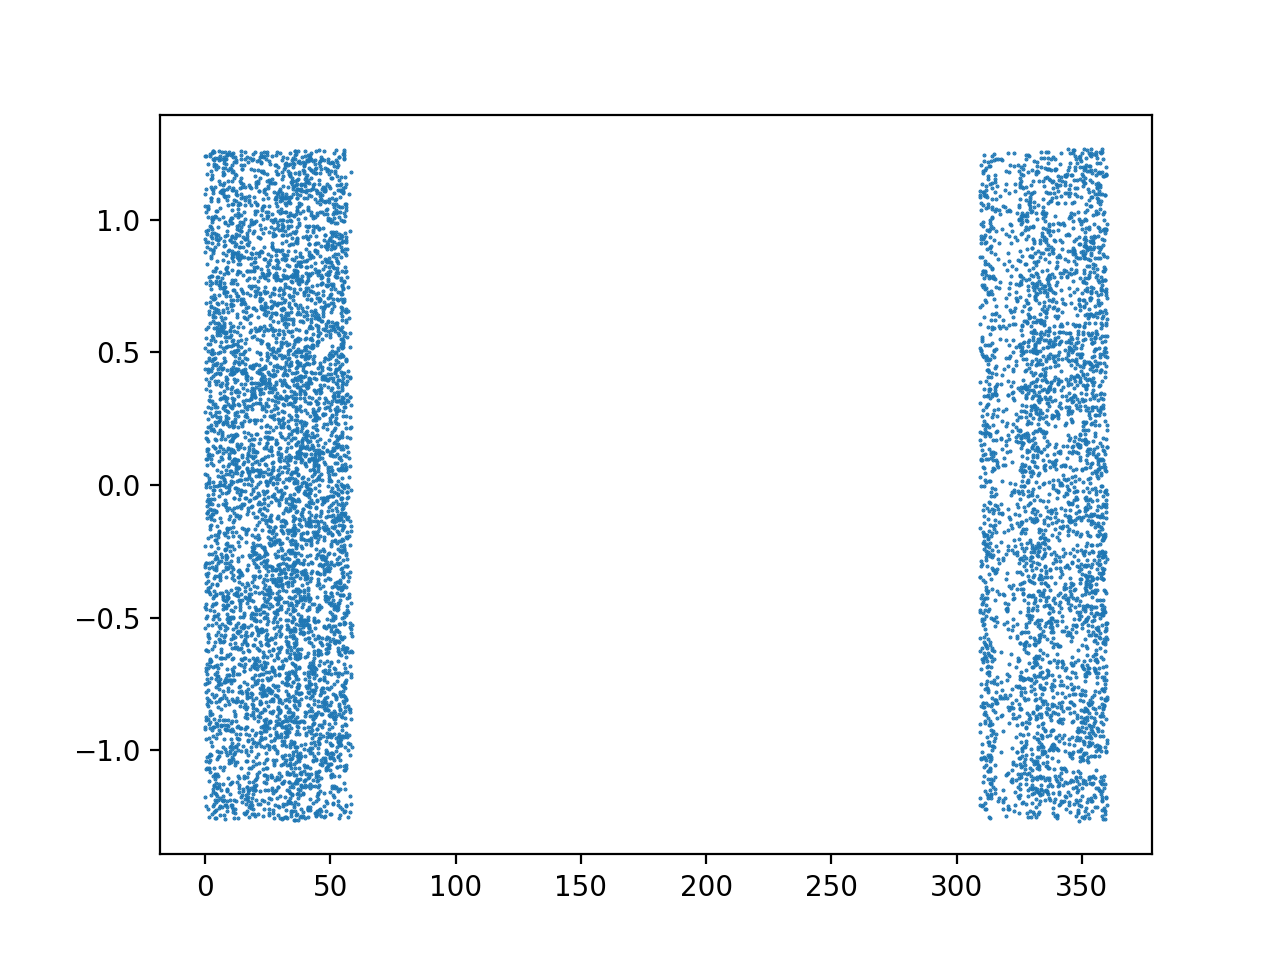

In [10]:
print(SDSS_DB_QSO['ra'].min(),SDSS_DB_QSO['ra'].max())
print(SDSS_DB_QSO['dec'].min(),SDSS_DB_QSO['dec'].max())
plt.scatter(SDSS_DB_QSO['ra'], SDSS_DB_QSO['dec'], s=0.2)

So let's get  all ZTF data for (  -1.3  < dec < 1.3 )  &&  ( 300 < ra < 360)  | ( 0 < ra < 55  ). (takes about a minute to run)

In [6]:
df = pd.read_sql_query('SELECT objectid, jd, fid, ra,decl,magpsf, sigmapsf \
FROM alerts WHERE (decl > -1.3) && (decl < 1.3)', con)  #  AND (0 < ra) && ( ra < 55) 

Now (8/17/18) with more data , there is some overlap :

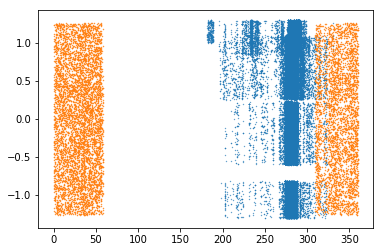

In [12]:
%matplotlib inline
plt.scatter(df['ra'], df['decl'], s=0.1)
plt.scatter(SDSS_DB_QSO['ra'], SDSS_DB_QSO['dec'], s=0.2)

Quasars are good to illustrate coverage because there's only 9258 of them.  Check if there are any matches : 

In [35]:
# Select only the portion of the ztf table that looks 'by eye' 
# from the above ra,dec plot to have some ZTF alerts...
ztf_s82 = Table.from_pandas(df[df['ra']>300])

ztf_coords = SkyCoord(ra=ztf_s82['ra'].data*u.degree, 
                      dec=ztf_s82['decl'].data*u.degree)
sdss_coords = SkyCoord(ra=SDSS_DB_QSO['ra']*u.degree, 
                       dec=SDSS_DB_QSO['dec']*u.degree)


# match SDSS Quasars to ZTF alerts since there is many less QSO than alerts ... 
idx, sep2d, dist3d = sdss_coords.match_to_catalog_sky(ztf_coords) 
SDSS_DB_QSO['d2d_arcsec']  = sep2d.value*3600


# Unfortunately, at this time there is none that is a good 
# match  to Schneider+2007  SDSS DB9  Quasars...
print(len(SDSS_DB_QSO[SDSS_DB_QSO['d2d_arcsec'] < 5]))

In [47]:
print('There are still ', len(np.unique(ztf_s82['objectid'])), ' ztf objects with ', len(ztf_s82),
      ' epochs total')

There are still  947  ztf objects with  1204  epochs total


Load the SDSS S82 Stars , and see if any at all matches against the ztf objects... Although with only 947 we may be running into small number statistics...  ? 

In [ ]:
# Can't use 
#>> from astroML.datasets import fetch_sdss_S82standards 
# - it'll take longer to 
# figure out how to install astroML than to 
# just scp the whole catalog ...
# I copy here the stripe82calibStars_v2.6.dat  from my computer



In [12]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']
fname = 'stripe82calibStars_v2.6.dat'
    
sdss_stars = Table.read(fname, format='ascii', names = colnames)

In [13]:
from astropy.table import unique

ztf_s82 = Table.from_pandas(df[df['ra']>300])
print(len(ztf_s82))
ztf_s82 = unique(ztf_s82, keys='objectid', keep='first')
print(len(ztf_s82))

1204
947


In [14]:
# crossmatch the ZTF alerts to SDSS stars ...


ztf_coords = SkyCoord(ra=ztf_s82['ra'].data*u.degree, 
                      dec=ztf_s82['decl'].data*u.degree)
sdss_coords = SkyCoord(ra=sdss_stars['ra']*u.degree, 
                       dec=sdss_stars['dec']*u.degree)


# match ZTF alerts to SDSS S82 standards  since there is many less ZTF alerts ... 
idx, sep2d, dist3d = ztf_coords.match_to_catalog_sky(sdss_coords) 
ztf_s82['d2d_arcsec']  = sep2d.value*3600



Any good matches ?

In [17]:
np.sum(ztf_s82['d2d_arcsec'] < 5 )

15

<a id='download_median_ztf'></a> That's not good enough.... Let's then download all unique ZTF objects, with aggregate median photometry

Aside: count how many objects there are ... 

In [3]:
%%time
ztf_counts = pd.read_sql_query('select count(*) as nobs from alerts GROUP BY objectId', con)

CPU times: user 1min 5s, sys: 12.4 s, total: 1min 17s
Wall time: 1min 19s


In [14]:
len(ztf_counts)

10670733

So there's 10 mln + objects, as of Aug 22 .

Aside : Check those that have over 500 counts 

In [29]:
%%time
interesting = pd.read_sql_query('select objectId, count(*) as nobs from alerts GROUP BY objectId HAVING nobs > 500', con)

CPU times: user 4.24 ms, sys: 1.04 ms, total: 5.28 ms
Wall time: 20.3 s


**Group by object Id**,  select only one filter  in each query  - 
that way I have essentially  g,r,i  observations 
fid : 1=g; 2=r; 3=i , 
where stellar classification is > 0.5  
( I could put the cut even higher, it's probably based on whether the objects are resolved 
or not ... )

In [32]:
%%time 
ztf_fid_df = pd.read_sql_query('select objectid, fid, classtar,\
 count(*) as nobs  ,  avg(magpsf) as avg_magpsf,\
 avg(sigmapsf) as avg_sigmapsf,\
 avg(ra) as avg_ra, avg(decl) as avg_decl ,\
 avg(jd) as avg_jd \
 from alerts WHERE fid ="3" and classtar > 0.5 \
 GROUP BY objectId    LIMIT 100000', con)



CPU times: user 541 ms, sys: 90 ms, total: 631 ms
Wall time: 14min 47s


In [36]:
#So there's only 26000 objects with observations in i filter ! 
len(ztf_fid_df)

26456

In [35]:
ztf_fid_table = Table.from_pandas(ztf_fid_df)
ztf_fid_table.write('ztf_alerts_i_hundred_thousand.txt', 
                    format='ascii')

Download the list of ra,dec , and upload to SciServer to cross match against all of the SDSS ... 

In [ ]:
Another way : 

This took 10 minutes! 

In [ ]:
ztf_all = Table.from_pandas(df)
ztf_all.write('ztf_alerts_objectId.txt', format='ascii')